In [1]:
# Run this code block just once after the kernel starts
# to change current directory to root

import sys
import os

sys.path.append("..")
os.chdir("..")
print(os.getcwd())

/home/student/bev-project


In [2]:
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import math
import matplotlib.pyplot as plt

from operator import mul
from functools import reduce

In [3]:
from dataset import NuScenesDataset


from models.pyramid.fpn import FPN50
from models.pyramid.resampler import Resampler


In [4]:
sample_tokens = ["d05e01e43df24e35a7b4f11647e250f6"]


dataset = NuScenesDataset(
    nuscenes_dir="/home/student/bev-project/nuscenes",
    nuscenes_version="v1.0-mini",
    label_dir="/home/student/bev-project/labels",
    sample_tokens=sample_tokens,
    image_size=(200, 112),
)

dataset_loader = DataLoader(
    dataset,
    batch_size=1,
    num_workers=2,
    pin_memory=True,
    shuffle=True,
)

--------------------------------------------------
Loading NuScenes version v1.0-mini ...
--------------------------------------------------


In [5]:
device = "cuda"

images, labels, masks, calibs = next(iter(dataset_loader))

images = images.to(device)
labels = labels.to(device)
masks = masks.to(device)
calibs = calibs.to(device)

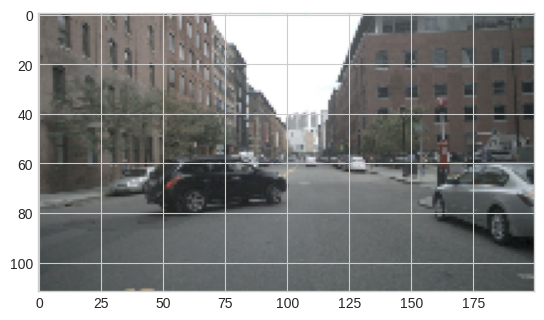

In [6]:
plt.imshow(images[0].cpu().permute(1,2,0))

In [6]:
from configs.config_utilities import load_config

config = load_config("configs/configs.yml")

# FPN

In [7]:
# forward image to fpn

fpn = FPN50().to(device=device)
image_features = fpn(images)

/home/student/miniconda3/envs/senior_project/lib/python3.8/site-packages/torch/nn/functional.py:3737: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


In [8]:
for feature in image_features:
    print(feature.shape)

torch.Size([1, 256, 14, 25])
torch.Size([1, 256, 7, 13])
torch.Size([1, 256, 4, 7])
torch.Size([1, 256, 2, 4])
torch.Size([1, 256, 1, 2])


# Existing Dense Transformer

In [9]:
class DenseTransformer(nn.Module):
    def __init__(
        self,
        in_channels,
        channels,
        resolution,
        grid_extents,
        ymin,
        ymax,
        focal_length,
        groups=1,
    ):
        super().__init__()

        self.focal_length = focal_length

        # Initial convolution to reduce feature dimensions
        self.conv = nn.Conv2d(in_channels, channels, 1)
        self.bn = nn.GroupNorm(16, channels)

        # Resampler transforms perspective features to BEV
        self.resampler = Resampler(resolution, grid_extents)

        # Compute input height based on region of image covered by grid
        self.zmin, zmax = grid_extents[1], grid_extents[3]
        self.in_height = math.ceil(focal_length * (ymax - ymin) / self.zmin)
        self.ymid = (ymin + ymax) / 2

        # Compute number of output cells required
        self.out_depth = math.ceil((zmax - self.zmin) / resolution)

        # Dense layer which maps UV features to UZ
        self.fc = nn.Conv1d(
            channels * self.in_height, channels * self.out_depth, 1, groups=groups
        )
        self.out_channels = channels

    def forward(self, features, calib, *args):
        # Crop feature maps to a fixed input height
        features = torch.stack(
            [self._crop_feature_map(fmap, cal) for fmap, cal in zip(features, calib)]
        )

        # Reduce feature dimension to minimize memory usage
        features = F.relu(self.bn(self.conv(features)))

        # Flatten height and channel dimensions
        B, C, _, W = features.shape
        flat_feats = features.flatten(1, 2)
        bev_feats = self.fc(flat_feats).view(B, C, -1, W)

        # Resample to orthographic grid
        return self.resampler(bev_feats, calib)

    def _crop_feature_map(self, fmap, calib):
        # Compute upper and lower bounds of visible region
        focal_length, img_offset = calib[1, 1:]
        vmid = self.ymid * focal_length / self.zmin + img_offset
        vmin = math.floor(vmid - self.in_height / 2)
        vmax = math.floor(vmid + self.in_height / 2)

        # Pad or crop input tensor to match dimensions
        return F.pad(fmap, [0, 0, -vmin, vmax - fmap.shape[-2]])

In [12]:
map_extents = [-25.0, 1.0, 25.0, 50.0]
focal_length = 630/8
ymin = -2
ymax = 4

In [13]:
image_features[0].shape

torch.Size([1, 256, 14, 25])

In [14]:
focal_length = config.focal_length
resolution = 0.5 # tfm_resolution
extents = config.map_extents

dense_tfms = list()

for i in range(5):
            
    # Scaled focal length for each transformer
    focal = focal_length / pow(2, i + 3)

    # Compute grid bounds for each transformer
    zmax = min(math.floor(focal * 2) * resolution, extents[3])
    zmin = math.floor(focal) * resolution if i < 4 else extents[1]
    subset_extents = [extents[0], zmin, extents[2], zmax]
    # Build transformers
    dense_tfm = DenseTransformer(
        in_channels=256, 
        channels=64, 
        resolution=resolution, 
        grid_extents=subset_extents,
        ymin=config.ymin, 
        ymax=config.ymax, 
        focal_length=focal
    ).to(device)
    
    dense_tfms.append(dense_tfm)

/home/student/miniconda3/envs/senior_project/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343998658/work/aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [15]:
bev_feats = list()

for i, fmap in enumerate(image_features):
    print(str(i) + "-"*10)
    print("fmap", fmap.shape)
    # Scale calibration matrix to account for downsampling
    scale = 8 * 2 ** i
    calib_downsamp = calibs.clone()
    calib_downsamp[:, :2] = calibs[:, :2] / scale

    # Apply orthographic transformation to each feature map separately
    print(calib_downsamp)
    print(calib_downsamp[:,1,1] / dense_tfms[i].focal_length)
    print(calib_downsamp[:,1,2] * calib_downsamp[:,1,1] / dense_tfms[i].focal_length)
    print(dense_tfms[i].in_height)
    bev_feat = dense_tfms[i](fmap, calib_downsamp)
    print(bev_feat.shape)
    bev_feats.append(bev_feat)

0----------
fmap torch.Size([1, 256, 14, 25])
tensor([[[19.7878,  0.0000, 12.7542],
         [ 0.0000, 19.6998,  7.6457],
         [ 0.0000,  0.0000,  1.0000]]], device='cuda:0')
tensor([0.2502], device='cuda:0')
tensor([1.9126], device='cuda:0')
13
torch.Size([1, 64, 22, 100])
1----------
fmap torch.Size([1, 256, 7, 13])
tensor([[[9.8939, 0.0000, 6.3771],
         [0.0000, 9.8499, 3.8228],
         [0.0000, 0.0000, 1.0000]]], device='cuda:0')
tensor([0.2502], device='cuda:0')
tensor([0.9563], device='cuda:0')
13
torch.Size([1, 64, 39, 100])
2----------
fmap torch.Size([1, 256, 4, 7])
tensor([[[4.9469, 0.0000, 3.1885],
         [0.0000, 4.9250, 1.9114],
         [0.0000, 0.0000, 1.0000]]], device='cuda:0')
tensor([0.2502], device='cuda:0')
tensor([0.4782], device='cuda:0')
13
torch.Size([1, 64, 20, 100])
3----------
fmap torch.Size([1, 256, 2, 4])
tensor([[[2.4735, 0.0000, 1.5943],
         [0.0000, 2.4625, 0.9557],
         [0.0000, 0.0000, 1.0000]]], device='cuda:0')
tensor([0.2502],

/home/student/miniconda3/envs/senior_project/lib/python3.8/site-packages/torch/nn/functional.py:4236: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


# Horizontal Dense Transformer

In [16]:
class HorizontalDenseTransformer(nn.Module):
    def __init__(
        self,
        in_channels,
        out_channels,
        resolution,
        grid_extents,
        ymin,
        ymax,
        xmin,
        xmax,
        zmin,
        zmax,
        focal_length,
        groups=1,
    ):
        super().__init__()

        # Initial convolution to reduce feature dimensions
        self.conv = nn.Conv2d(in_channels, out_channels, 1)
        self.bn = nn.GroupNorm(16, out_channels)

        # Resampler transforms perspective features to BEV
        self.resampler = Resampler(resolution, [xmin, zmin, xmax, zmax])

        # Compute input height based on region of image covered by grid
        self.zmin, self.zmax = grid_extents[1], grid_extents[3]
        self.xmin, self.xmax = grid_extents[0], grid_extents[2]

        # self.in_height = math.ceil(focal_length * (ymax - ymin) / self.zmin)
        # print("in_height", self.in_height)

        self.in_width =  math.ceil(resolution * focal_length * (xmax - xmin) / zmax ) 

        # Compute number of output cells required
        self.fpn_out_width = math.ceil((self.zmax - self.zmin) / resolution) # accurate fpn value
        self.out_depth = math.ceil((zmax - zmin) / resolution)

        print("fpn out_width", self.fpn_out_width)
        print("in_width", self.in_width)
        print("out_depth", self.out_depth)

        # Dense layer which maps UV features to UZ
        self.fc = nn.Conv1d(
            out_channels * self.in_width,
            out_channels * self.out_depth,
            1,
            groups=groups,
        )
        self.out_channels = out_channels

    def forward(self, features, calib, *args):

        # Reduce feature dimension to minimize memory usage
        features = F.relu(self.bn(self.conv(features)))
        print("relu feat", features.shape)
        
        # Bottlenecks
        B, C, H, W = features.shape
        flat_feats = features.permute(0,1,3,2).flatten(1, 2)  # (B, C*W, H)
        print("flat_feats", flat_feats.shape)

        
        bev_feats = self.fc(flat_feats).view(B, C, H, -1)
        print("bev_feats", bev_feats.shape)

        # Resample to orthographic grid
        return self.resampler(bev_feats, calib)

In [17]:
focal_length = config.focal_length
resolution = config.map_resolution
extents = config.map_extents

h_dense_tfms = list()

for i in range(5):
            
    # Scaled focal length for each transformer
    focal = focal_length / pow(2, i + 3)

    xmin = extents[0] / pow(2, i + 3) 
    zmin = extents[1] / pow(2, i + 3)
    xmax = extents[2] / pow(2, i + 3)
    zmax = extents[3] / pow(2, i + 3)

    subset_extents = [xmin, zmin, xmax, zmax]


    # Build transformers
    dense_tfm = HorizontalDenseTransformer(
        in_channels=256, 
        out_channels=64, 
        resolution=resolution, 
        grid_extents=subset_extents,
        ymin=config.ymin, 
        ymax=config.ymax, 
        xmin=extents[0],
        xmax=extents[2],
        zmin=extents[1],
        zmax=extents[3],
        focal_length=focal
    ).to(device)
    
    h_dense_tfms.append(dense_tfm)

fpn out_width 25
in_width 20
out_depth 196
fpn out_width 13
in_width 10
out_depth 196
fpn out_width 7
in_width 5
out_depth 196
fpn out_width 4
in_width 3
out_depth 196
fpn out_width 2
in_width 2
out_depth 196


In [18]:
h_bev_feats = list()

for i, fmap in enumerate(image_features):
    print(str(i) + " " + "-"*10)
    print("fmap", fmap.shape)
    # Scale calibration matrix to account for downsampling
    scale = 8 * 2 ** i
    calib_downsamp = calibs.clone()
    calib_downsamp[:, :2] = calibs[:, :2] / scale

    # Resize fmap
    fmap = F.interpolate(fmap, size=(fmap.shape[2], h_dense_tfms[i].in_width))

    # Apply orthographic transformation to each feature map separately
    bev_feat = h_dense_tfms[i](fmap, calib_downsamp)
    print(bev_feat.shape)
    h_bev_feats.append(bev_feat)

0 ----------
fmap torch.Size([1, 256, 14, 25])
relu feat torch.Size([1, 64, 14, 20])
flat_feats torch.Size([1, 1280, 14])
bev_feats torch.Size([1, 64, 14, 196])
torch.Size([1, 64, 196, 200])
1 ----------
fmap torch.Size([1, 256, 7, 13])
relu feat torch.Size([1, 64, 7, 10])
flat_feats torch.Size([1, 640, 7])
bev_feats torch.Size([1, 64, 7, 196])
torch.Size([1, 64, 196, 200])
2 ----------
fmap torch.Size([1, 256, 4, 7])
relu feat torch.Size([1, 64, 4, 5])
flat_feats torch.Size([1, 320, 4])
bev_feats torch.Size([1, 64, 4, 196])
torch.Size([1, 64, 196, 200])
3 ----------
fmap torch.Size([1, 256, 2, 4])
relu feat torch.Size([1, 64, 2, 3])
flat_feats torch.Size([1, 192, 2])
bev_feats torch.Size([1, 64, 2, 196])
torch.Size([1, 64, 196, 200])
4 ----------
fmap torch.Size([1, 256, 1, 2])
relu feat torch.Size([1, 64, 1, 2])
flat_feats torch.Size([1, 128, 1])
bev_feats torch.Size([1, 64, 1, 196])
torch.Size([1, 64, 196, 200])


# Concatenate both bev features

In [19]:
for i, bev_feat in enumerate(bev_feats):
    print(i, bev_feat.shape)

0 torch.Size([1, 64, 22, 100])
1 torch.Size([1, 64, 39, 100])
2 torch.Size([1, 64, 20, 100])
3 torch.Size([1, 64, 10, 100])
4 torch.Size([1, 64, 7, 100])


In [20]:
for i, bev_feat in enumerate(h_bev_feats):
    print(i, bev_feat.shape)

0 torch.Size([1, 64, 196, 200])
1 torch.Size([1, 64, 196, 200])
2 torch.Size([1, 64, 196, 200])
3 torch.Size([1, 64, 196, 200])
4 torch.Size([1, 64, 196, 200])


In [21]:
torch.cat(bev_feats[::-1], dim=-2).shape

torch.Size([1, 64, 98, 100])

In [22]:
num_layers = len(h_bev_feats)
W = 100
slice_width = math.floor(W/(num_layers*2))
for i in range(num_layers):
    print(f"layer {i} " + "-" *5)
    print("left slice", end=" ")
    print(f"{i*slice_width}:{(i+1)*slice_width}")
    print("right slice", end=" ")
    if i == num_layers - 1:
        print(f"{(i+1)*slice_width}:{W - (slice_width * i)}")
    else:
        print(f"{W - (slice_width * (i + 1))}:{W - (slice_width * i)}")    

layer 0 -----
left slice 0:10
right slice 90:100
layer 1 -----
left slice 10:20
right slice 80:90
layer 2 -----
left slice 20:30
right slice 70:80
layer 3 -----
left slice 30:40
right slice 60:70
layer 4 -----
left slice 40:50
right slice 50:60


In [23]:
def arrange_h_bev_feats(h_bev_feats):
    W = h_bev_feats[0].shape[3]
    num_layers = len(h_bev_feats)
    slice_width = W // (num_layers*2)

    left_slices = []
    right_slices = []

    for i, feature in enumerate(h_bev_feats):
        # arrange left side
        left_lower_bound, left_uppper_bound  = i*slice_width, (i+1)*slice_width
        left_slice = feature[:, :, :, left_lower_bound:left_uppper_bound]
        left_slices.append(left_slice)

        # arange right side    
        if i == num_layers - 1:
            right_lower_bound, right_upper_bound = (i+1)*slice_width, W - (slice_width * i)
        else:
            right_lower_bound, right_upper_bound = W - (slice_width * (i + 1)), W - (slice_width * i)

        right_slice = feature[:, :, :, right_lower_bound:right_upper_bound]
        right_slices.append(right_slice)

        
    final_h_bev_feats = torch.cat((*left_slices, *right_slices[::-1]), dim=3)
    
    return final_h_bev_feats
